In [1]:
import numpy as np
import libdl as l
import time
import torch, torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
np.random.seed(0)

In [2]:
# A small helperfunction that instanciates my own tensors from a numpy array
def from_numpy(a, requiresGrad=False):
    a = np.array(a)
    if len(a.shape) == 1:
        return l.Tensor1(np.asfortranarray(a).astype(np.float32), requiresGrad)
    elif len(a.shape) == 2:
        return l.Tensor2(np.asfortranarray(a).astype(np.float32), requiresGrad)
    elif len(a.shape) == 3:
        return l.Tensor3(np.asfortranarray(a).astype(np.float32), requiresGrad)
    elif len(a.shape) == 4:
        return l.Tensor4(np.asfortranarray(a).astype(np.float32), requiresGrad)

In [3]:
# hyperparameter
lr = .1
momentum = .5
lr_decay = .98
filter_sizes = [5, 5]
hidden_units = [16, 32, 64]
batch_size = 64
log_every = 10

In [4]:
# dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])
train_data = MNIST('dataset/', train=True, download=True, transform=transform)
test_data = MNIST('dataset/', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [5]:
# weights and biases for the convolutional neural network
F1 = from_numpy(np.random.normal(0, 1 / np.sqrt(filter_sizes[0] * filter_sizes[0]), (filter_sizes[0], filter_sizes[0], 1, hidden_units[0])), True)
B1 = from_numpy(np.zeros(hidden_units[0]), True)
F2 = from_numpy(np.random.normal(0, 1 / np.sqrt(hidden_units[0] * filter_sizes[1] * filter_sizes[1]), (filter_sizes[1], filter_sizes[1], hidden_units[0], hidden_units[1])), True)
B2 = from_numpy(np.zeros(hidden_units[1]), True)

W3 = from_numpy(np.random.normal(0, 1 / np.sqrt(49 * hidden_units[1]), (hidden_units[2], 49 * hidden_units[1])), True)
B3 = from_numpy(np.zeros(hidden_units[2]), True)
W4 = from_numpy(np.random.normal(0, 1 / np.sqrt(hidden_units[2]), (10, hidden_units[2])), True)
B4 = from_numpy(np.zeros(10), True)
parameters = [F1, B1, F2, B2, W3, B3, W4, B4]

In [6]:
# forward pass
def forward(x):
    h1 = l.leakyRelu(l.maxpool2d(l.conv2d(x, F1, B1, filter_sizes[0] // 2), 2))
    h2 = l.leakyRelu(l.maxpool2d(l.conv2d(h1, F2, B2, filter_sizes[1] // 2), 2))
    h2 = l.reshape(h2, (49 * hidden_units[1], -1))
    h3 = l.leakyRelu(l.matmul(W3, h2) + B3)
    return l.matmul(W4, h3) + B4

In [7]:
# training
print("Iteration | Loss")
start_time = time.time()
for i, (x, y) in enumerate(train_loader):
    x = from_numpy(x.numpy().transpose())
    y = from_numpy(np.eye(10)[y.numpy()].transpose())  # onehot encoding

    yp = forward(x)
    loss = l.crossEntropyWithLogits(yp, y)
    loss.backward()
    
    for p in parameters:
        p.applyGradient(lr)
        g = p.grad() 
        g *= momentum
    lr *= lr_decay
    
    if i % log_every == 0:
        print(f"{i:9d} | {loss.numpy():.4f}")
    
    if i >= 50: # Only train for 50 iterations. That's enough to show that my library works
        break

print(f'Trainig took: {time.time() - start_time:.2f}s')

Iteration | Loss
        0 | 2.2883
       10 | 1.7593
       20 | 1.6360
       30 | 1.0481
       40 | 0.5559
       50 | 0.4943
Trainig took: 26.42s


In [8]:
# test accuracy
accs = []
for i, (x, y) in enumerate(test_loader):
    x = from_numpy(x.numpy().transpose())
    y = y.numpy()

    yp = forward(x).numpy().argmax(axis=0)
    accs.append(np.mean(yp == y))
    if i >= 10:
        break

print(f"Test accuracy: {np.mean(accs)*100:.2f}%")

Test accuracy: 85.80%


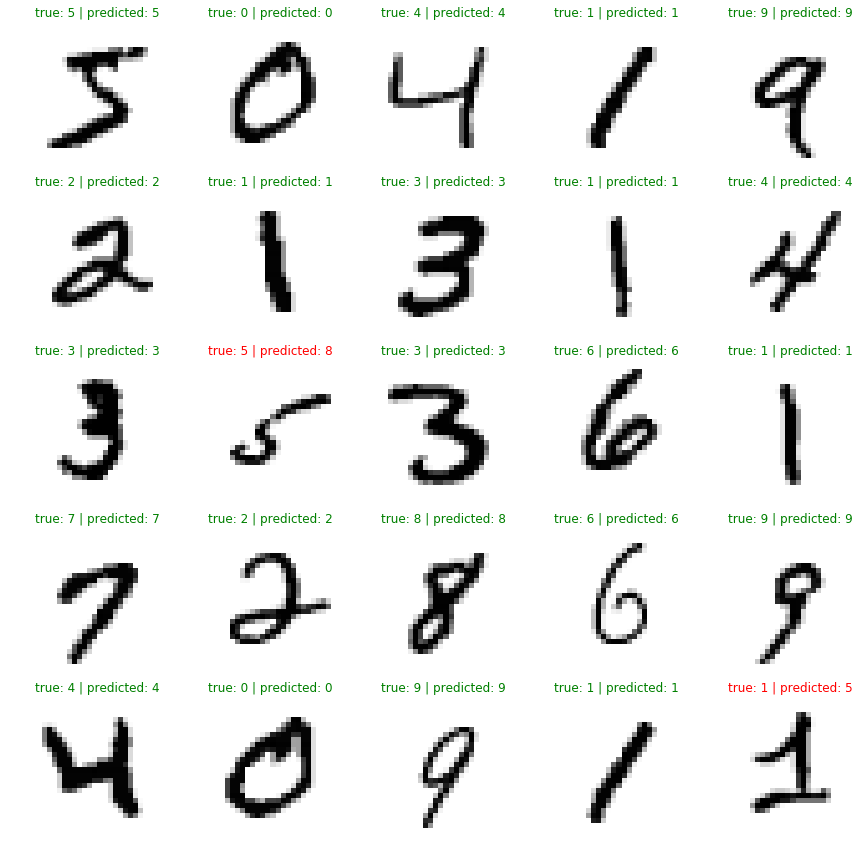

In [9]:
# visualization
grid_size = 5
t = from_numpy(np.concatenate([train_data[i][0][None] for i in range(grid_size * grid_size)]).transpose())
lp = forward(t).numpy().argmax(axis=0)
gs = gridspec.GridSpec(grid_size, grid_size)
plt.figure(figsize=(15,15)) 
for i in range(grid_size*grid_size):
    plt.subplot(gs[i])
    plt.axis('off')
    plt.title(f'true: {train_data[i][1]} | predicted: {lp[i]}', color='g' if train_data[i][1] == lp[i] else 'r')
    plt.imshow(1-train_data[i][0].numpy().squeeze(), cmap='gray')